In [1]:
import os
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import os
from joblib import Parallel, delayed
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
L = 40
# MCMC 샘플링
def energy_general_ising(seq, b, w):
    field_term = -np.dot(b, seq)
    interaction_term = -np.sum(np.triu(w, k=1) * np.outer(seq, seq))
    return field_term + interaction_term

def metropolis_sample(L, b, w, beta=1.0, n_steps=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    seq = np.random.choice([-1, 1], size=L)
    local_field = b + np.dot(w, seq)

    for step in range(n_steps):
        i = np.random.randint(L)
        dE = 2 * seq[i] * local_field[i]

        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            seq[i] *= -1
            local_field += 2 * w[:, i] * seq[i]

    return seq

def sample_general_ising(L, N, b, w, beta=1.0, n_steps=1000, n_jobs=10):
    from joblib import parallel_backend

    seeds = np.random.randint(0, 1e6, size=N)
    with parallel_backend('loky'):
        samples = Parallel(n_jobs=n_jobs)(
            delayed(metropolis_sample)(L, b, w, beta, n_steps, int(seeds[i]))
            for i in tqdm(range(N), desc="Sampling Ising states", unit="sample")
        )

    return np.array(samples)

#에너지 분포 히스토그램
def plot_energy_histogram_general(samples, b, w, color='cornflowerblue', bins = 30, label=None):
    energies = np.array([energy_general_ising(s, b, w) for s in samples])
    if label == None :
        plt.hist(energies, bins=bins, density=True, color=color, edgecolor='black', alpha = 0.6)
    else :
        plt.hist(energies, bins=bins, density=True, color=color, edgecolor='black', alpha = 0.6, label=label)
        
    #plt.title(f"Ising Model Energy Histogram L = {L}")
    plt.xlabel("Energy")
    plt.ylabel("A.U.")
    plt.grid(True)

#선형회귀 III
import numpy as np
from sklearn.linear_model import LogisticRegression

def inverse_ising_logistic(data):
    M, n = data.shape
    W = np.zeros((n, n))
    b = np.zeros(n)

    for i in range(n):
        y = data[:, i]
        X = np.delete(data, i, axis=1)
        
        y_binary = (y + 1) // 2

        clf = LogisticRegression(penalty='l2', solver='lbfgs')
        clf.fit(X, y_binary)

        b[i] = clf.intercept_[0] / 2.0
        w_i = clf.coef_[0] / 2.0
        W[i, np.arange(n) != i] = w_i

    W = (W + W.T) / 2.0
    return b, W

#erasure machine
def compute_energy_torch(samples, b, w):
    # energy = -b·σ - sum_{i<j} w_ij σ_i σ_j
    field_term = -torch.matmul(samples, b)
    interaction_term = -0.5 * torch.sum(samples @ w * samples, dim=1)
    return field_term + interaction_term

def estimate_f_epsilon_torch(samples, b, w, epsilon):
    with torch.no_grad():
        energies = compute_energy_torch(samples, b, w)
        ps = torch.exp(-energies)
        ps_epsilon = ps ** (-1 + epsilon)
        weights = ps_epsilon / ps_epsilon.sum()
    return weights

def update_parameters_torch(samples, b, w, epsilon, lr):
    weights = estimate_f_epsilon_torch(samples, b, w, epsilon)

    mean_sigma = torch.sum(weights[:, None] * samples, dim=0)

    outer = samples.unsqueeze(2) * samples.unsqueeze(1)  # shape: (N, L, L)
    weighted_outer = weights[:, None, None] * outer
    mean_sigma_sigma = torch.sum(weighted_outer, dim=0)
    mean_sigma_sigma.fill_diagonal_(0.0)

    b_model = epsilon * b
    w_model = epsilon * w

    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)

    return b_new, w_new

def train_erasure_machine_torch(samples_np, n, epsilon=0.05, lr=0.1, epochs=100, use_cuda=True):
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    samples = torch.tensor(samples_np, dtype=torch.float32, device=device)

    b = torch.randn(n, device=device) * 0.01
    w = torch.randn(n, n, device=device) * 0.01
    w = (w + w.T) / 2
    w.fill_diagonal_(0.0)

    for epoch in range(epochs):
        b, w = update_parameters_torch(samples, b, w, epsilon, lr)
        if epoch % 10 == 0:
            print(f"[GPU] Epoch {epoch}: b norm = {b.norm():.4f}, w norm = {w.norm():.4f}")
    return b.cpu().numpy(), w.cpu().numpy()

#mse 계산
def mse(w, w_e, b, b_e) :
    LL = L + L*(L-1)/2
    b_error = np.sum((b_e - b)**2)/LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_e - w) * mask
    w_error = np.sum(w_diff**2)/LL
    return (b_error + w_error)

In [43]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -(np.log(10000) / (half_dim-1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=40, n_class=2, embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(n_class+1, embed_dim)
        time_embed_dim = 128
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)
        self.enc1 = nn.Linear(input_dim + time_embed_dim + embed_dim, 128)
        self.enc2 = nn.Linear(128, 256)
        self.enc3 = nn.Linear(256, 512)
        self.dec1 = nn.Linear(512, 512)
        self.dec2 = nn.Linear(512, 512)
        self.dec3 = nn.Linear(512, 256)
        self.dec4 = nn.Linear(256, 128)
        self.out = nn.Linear(128, input_dim)
        self.act = nn.GELU()
    def forward(self, x, t, y):
        t_embed = self.time_embed(t).to(x.dtype)
        y_embed = self.embedding(y).to(x.dtype)
        h = torch.cat([x, t_embed, y_embed], dim=1)
        h1 = self.act(self.enc1(h))
        h2 = self.act(self.enc2(h1))
        h3 = self.act(self.enc3(h2))
        d1 = self.act(self.dec1(h3))
        d2 = self.act(self.dec2(d1) + d1)
        d3 = self.act(self.dec3(d2) + h2)
        d4 = self.act(self.dec4(d3) + h1)
        return self.out(d4)

# ------------------------------
# 3. DDPM 정의
# ------------------------------
class DDPM(nn.Module):
    def __init__(self, model, beta_start=0.001, beta_end=0.02, n_T=1000, device='cuda'):
        super().__init__()
        self.model = model
        self.n_T = n_T
        self.device = device

        betas = torch.linspace(beta_start, beta_end, n_T).to(device)
        alphas = 1 - betas
        alphabar = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphabar", alphabar)
        self.register_buffer("sqrtab", torch.sqrt(alphabar))
        self.register_buffer("sqrtmab", torch.sqrt(1 - alphabar))
        self.register_buffer("oneover_sqrta", 1 / torch.sqrt(alphas))
        self.register_buffer("bt_over_sqrtmab", betas / torch.sqrt(1 - alphabar))
        self.register_buffer("sqrt_beta_t", torch.sqrt(betas))

    def forward(self, x, y):
        B = x.shape[0]
        t = torch.randint(1, self.n_T+1, (B,), device=x.device).float()
        sqrtab_t = self.sqrtab[t.long()-1].view(B, 1)
        sqrtmab_t = self.sqrtmab[t.long()-1].view(B, 1)
        eps = torch.randn_like(x)
        x_t = sqrtab_t * x + sqrtmab_t * eps
        eps_pred = self.model(x_t, t, y)
        return F.mse_loss(eps_pred, eps)


# ------------------------------
# 5. Training Loop & 샘플링
# ------------------------------
# 모델 인스턴스 생성 (구조 동일해야 함!)
n_class = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionMLP(n_class=n_class).to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("model_epoch_18000.pth"))
model.eval() 
ddpm = DDPM(model, device=device).to(device)
b = np.load("ising_h.npy")
w = np.load("ising_J.npy")
sams = np.load("ising_samples.npy")
# Uncond sampling
n_sample = 5000
guidance_scale = 1.0

N = 40  

# Uncond 샘플
x_null = torch.randn(n_sample, N).to(device)
print(ddpm.n_T)
with torch.no_grad():
    for t in reversed(range(1, ddpm.n_T + 1)):
        print(t)
        t_batch = torch.full((n_sample,), t, device=device).float()
        eps = model(x_null, t_batch, torch.ones(n_sample, device=device, dtype=torch.long) * n_class)
        mu = ddpm.oneover_sqrta[t-1] * (x_null - ddpm.bt_over_sqrtmab[t-1] * eps)
        sigma = ddpm.sqrt_beta_t[t-1]
        z = torch.randn_like(x_null) if t > 1 else torch.zeros_like(x_null)
        x_null = mu + sigma * z
x_null = x_null.detach().cpu().numpy()

1000
1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
75

In [45]:
og_null = np.vstack([sams, x_null])
epsilon=0.7
epo=200
b_learned, w_learned = train_erasure_machine_torch(sams, 40, epsilon=epsilon, epochs=epo)
b_learned_null, w_learned_null = train_erasure_machine_torch(og_null, 40, epsilon=epsilon, epochs=epo)

[GPU] Epoch 0: b norm = 0.2241, w norm = 0.6868
[GPU] Epoch 10: b norm = 0.8982, w norm = 3.0494
[GPU] Epoch 20: b norm = 1.1110, w norm = 3.8443
[GPU] Epoch 30: b norm = 1.1989, w norm = 4.1658
[GPU] Epoch 40: b norm = 1.2373, w norm = 4.3019
[GPU] Epoch 50: b norm = 1.2543, w norm = 4.3608
[GPU] Epoch 60: b norm = 1.2619, w norm = 4.3865
[GPU] Epoch 70: b norm = 1.2654, w norm = 4.3979
[GPU] Epoch 80: b norm = 1.2669, w norm = 4.4029
[GPU] Epoch 90: b norm = 1.2676, w norm = 4.4052
[GPU] Epoch 100: b norm = 1.2680, w norm = 4.4062
[GPU] Epoch 110: b norm = 1.2681, w norm = 4.4066
[GPU] Epoch 120: b norm = 1.2682, w norm = 4.4068
[GPU] Epoch 130: b norm = 1.2682, w norm = 4.4069
[GPU] Epoch 140: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch 150: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch 160: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch 170: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch 180: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch 190: b norm = 1.2682, w norm = 4.4070
[GPU] Epoch

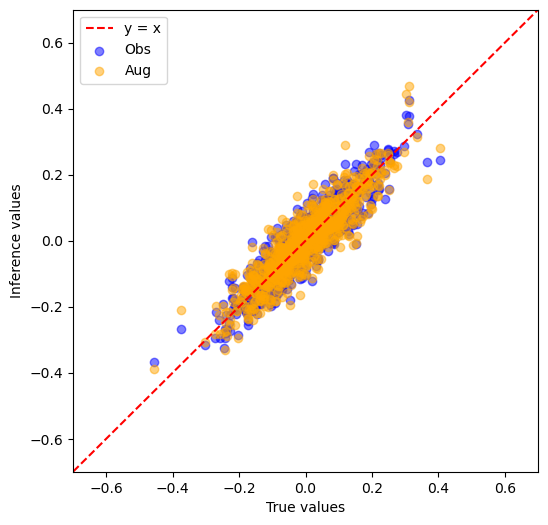

0.002205053503530054
0.0025941701395349203
5000
5000


In [48]:
x = np.concatenate([b, w[np.triu_indices_from(w, k=1)]])
y = np.concatenate([b_learned, w_learned[np.triu_indices_from(w_learned, k=1)]])
y_2 = np.concatenate([b_learned_null, w_learned_null[np.triu_indices_from(w, k=1)]])
plt.figure(figsize=(6, 6))
plt.plot([-3, 3], [-3, 3], 'r--', label='y = x')

# 산점도
plt.scatter(x, y, label='Obs', color='blue', alpha=0.5)
plt.scatter(x, y_2, label='Aug', color='orange', alpha=0.5)

# 축 설정
plt.xlabel("True values")
plt.ylabel("Inference values")
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.legend()

plt.show()


print(mse(w, w_learned, b, b_learned))
print(mse(w, w_learned_null, b, b_learned_null))
print(sams.shape[0])
print(x_null.shape[0])


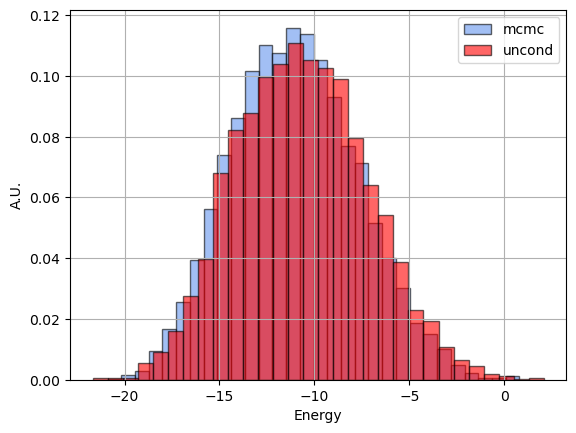

In [51]:
plot_energy_histogram_general(sams, b, w, label='mcmc')
plot_energy_histogram_general(x_null, b, w, 'red', label='uncond')
plt.legend()
plt.show()